In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window, Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql import types as T
import pandas as pd
from pyspark.sql.window import Window

In [2]:
from pyspark.ml.regression import *
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *

In [3]:
import numpy as np

In [4]:
most_corr_cols = [
    "battl",
    "case_death",
    "coronaviru_lockdown",
    "covid_lockdown",
    "covid_patient",
    "death",
    "donat",
    "equip",
    "hero",
    "lockdown",
    "new_york",
    "nurs",
    "polic",
    "ppe",
    "stayhom",
    "stayhomesavel",
    "staysaf",
    "total",
    "ventil",
    "york"
]

In [5]:
spark = SparkSession.builder.appName('Combine models').getOrCreate()

In [6]:
df_cases = spark.read.csv('covid_numconf.csv', header=True)
df_words = spark.read.csv('word_count_pivot.csv', header=True)
df_sir = spark.read.csv('sir_prediction.csv', header=True)

In [7]:
df_cases = df_cases.select(
        'date',
        F.col('numconf').cast('Long'),
        F.lit(1).alias('temp'))

df_sir = df_sir.select(
        'date',
        F.col('predict_infection').cast('Float'),)

df_words = df_words.select('date', *most_corr_cols)

In [32]:
window = Window.partitionBy('temp').orderBy('date')

data = df_words.join(df_cases, on='date', how='right')\
            .join(df_sir, on='date', how='left')\
            .select(
                'date',
                F.date_add('date', 4).alias('prediction_date'),
                F.lead('numconf', 4).over(window).alias('label'),
#                 'numconf',
                F.lead(F.col('predict_infection').alias('baseline_prediction'),4)\
                        .over(window).alias('sir_prediction'),
                *[F.col(c).cast('Long') for c in most_corr_cols]
            )

In [33]:
data.toPandas()

,date,prediction_date,label,sir_prediction,battl,case_death,coronaviru_lockdown,covid_lockdown,covid_patient,death,...,new_york,nurs,polic,ppe,stayhom,stayhomesavel,staysaf,total,ventil,york
0,2020-03-01,2020-03-05,45.0,52.840332,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,2020-03-06,51.0,64.365578,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,2020-03-07,57.0,78.404640,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,2020-03-08,62.0,95.505798,15.0,94.0,0.0,0.0,6.0,380.0,...,27.0,20.0,5.0,8.0,0.0,0.0,2.0,232.0,2.0,28.0
4,2020-03-05,2020-03-09,77.0,116.336891,38.0,156.0,3.0,2.0,28.0,714.0,...,37.0,58.0,29.0,13.0,0.0,0.0,19.0,422.0,4.0,39.0
5,2020-03-06,2020-03-10,90.0,141.711487,20.0,137.0,2.0,0.0,21.0,546.0,...,39.0,62.0,18.0,5.0,0.0,0.0,22.0,432.0,1.0,39.0
6,2020-03-07,2020-03-11,103.0,172.620361,19.0,153.0,2.0,0.0,11.0,492.0,...,46.0,34.0,33.0,6.0,1.0,0.0,15.0,360.0,5.0,46.0
7,2020-03-08,2020-03-12,138.0,210.270691,13.0,92.0,5.0,2.0,12.0,448.0,...,45.0,39.0,29.0,3.0,1.0,0.0,5.0,265.0,0.0,45.0
8,2020-03-09,2020-03-13,176.0,256.132690,57.0,233.0,29.0,16.0,49.0,1219.0,...,133.0,129.0,58.0,19.0,3.0,0.0,36.0,776.0,16.0,136.0
9,2020-03-10,2020-03-14,193.0,311.997192,199.0,509.0,69.0,47.0,348.0,3260.0,...,437.0,589.0,158.0,97.0,26.0,0.0,90.0,1855.0,122.0,448.0


In [34]:
train_data = data.filter(F.col('date') > '2020-03-04').filter(F.col('date') <= '2020-03-26')
test_data = data.filter(F.col('date') > '2020-03-27').filter(F.col('date') <= '2020-03-31')
full_data = data.filter(F.col('date') > '2020-03-04').filter(F.col('date') <= '2020-03-31')

In [35]:
feature_cols = train_data.columns[3:]
feature_cols

['sir_prediction',
 'battl',
 'case_death',
 'coronaviru_lockdown',
 'covid_lockdown',
 'covid_patient',
 'death',
 'donat',
 'equip',
 'hero',
 'lockdown',
 'new_york',
 'nurs',
 'polic',
 'ppe',
 'stayhom',
 'stayhomesavel',
 'staysaf',
 'total',
 'ventil',
 'york']

In [36]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)
full_data = assembler.transform(full_data)

In [37]:
train_data = train_data.select(['features', 'label', 'date', 'prediction_date', 'sir_prediction'])
test_data = test_data.select(['features', 'label', 'date', 'prediction_date', 'sir_prediction'])
full_data = full_data.select(['features', 'label', 'date', 'prediction_date', 'sir_prediction'])

In [38]:
test_data.toPandas()

,features,label,date,prediction_date,sir_prediction
0,"[10862.771484375, 1503.0, 1552.0, 1345.0, 1809...",9595,2020-03-28,2020-04-01,10862.771484
1,"[13227.9521484375, 1530.0, 1631.0, 1434.0, 193...",11268,2020-03-29,2020-04-02,13227.952148
2,"[16107.0029296875, 1489.0, 1345.0, 2422.0, 252...",12519,2020-03-30,2020-04-03,16107.002930
3,"[19611.037109375, 1855.0, 1479.0, 1905.0, 2486...",13882,2020-03-31,2020-04-04,19611.037109


In [39]:
lr = LinearRegression(featuresCol='features', labelCol='label', 
                        maxIter=1000, regParam=0.5)
model = lr.fit(train_data)

In [40]:
prediction_train = model.transform(train_data)
prediction_test = model.transform(test_data)
prediction_full = model.transform(full_data)

In [41]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", 
                                metricName="rmse")

In [42]:
rmse_train = evaluator.evaluate(prediction_train)
rmse_test = evaluator.evaluate(prediction_test)
print("Root Mean Squared Error (RMSE) on training data = %g" % rmse_train)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_test)

Root Mean Squared Error (RMSE) on training data = 8.47838
Root Mean Squared Error (RMSE) on test data = 484.97


In [43]:
result_train = prediction_train.toPandas()
result_test = prediction_test.toPandas()
result_full = prediction_full.toPandas()

In [44]:
np.abs(result_test['prediction'] - result_test['label'])/result_test['label']

0    0.037261
1    0.029801
2    0.034566
3    0.051593
dtype: float64

In [45]:
result_test

,features,label,date,prediction_date,sir_prediction,prediction
0,"[10862.771484375, 1503.0, 1552.0, 1345.0, 1809...",9595,2020-03-28,2020-04-01,10862.771484,9237.483988
1,"[13227.9521484375, 1530.0, 1631.0, 1434.0, 193...",11268,2020-03-29,2020-04-02,13227.952148,10932.205062
2,"[16107.0029296875, 1489.0, 1345.0, 2422.0, 252...",12519,2020-03-30,2020-04-03,16107.002930,12951.729870
3,"[19611.037109375, 1855.0, 1479.0, 1905.0, 2486...",13882,2020-03-31,2020-04-04,19611.037109,14598.208179


In [46]:
result_sir = df_sir.toPandas()

In [47]:
final_result = result_full.rename(columns={
        'prediction': 'full_model_prediction',
        'sir_prediction': 'sir_model_prediction',
        'label': 'true_value'
    })[['prediction_date', 'true_value', 'sir_model_prediction', 'full_model_prediction']]

In [48]:
final_result

,prediction_date,true_value,sir_model_prediction,full_model_prediction
0,2020-03-09,77,116.336891,90.916384
1,2020-03-10,90,141.711487,90.442225
2,2020-03-11,103,172.620361,124.160698
3,2020-03-12,138,210.270691,114.759546
4,2020-03-13,176,256.132690,162.136244
5,2020-03-14,193,311.997192,194.578281
6,2020-03-15,249,380.045563,244.264135
7,2020-03-16,324,462.934753,326.830215
8,2020-03-17,424,563.901001,424.230164
9,2020-03-18,569,686.885986,572.701329


In [65]:
final_result_train = final_result.iloc[:-4]
final_result_test = final_result.iloc[-4:]

In [66]:
np.abs(final_result_test["full_model_prediction"] - final_result_test["true_value"]) / final_result_test["true_value"]

23    0.037261
24    0.029801
25    0.034566
26    0.051593
dtype: float64

In [67]:
RMSE_train = ((final_result_train["full_model_prediction"] - final_result_train["true_value"]) ** 2).mean() ** .5
RMSE_test = ((final_result_test["full_model_prediction"] - final_result_test["true_value"]) ** 2).mean() ** .5
MAPE_train = (np.abs(final_result_train["full_model_prediction"] - final_result_train["true_value"]) / final_result_train["true_value"]).mean()
MAPE_test = (np.abs(final_result_test["full_model_prediction"] - final_result_test["true_value"]) / final_result_test["true_value"]).mean()
print(RMSE_train, RMSE_test, MAPE_train, MAPE_test)

78.33900361488784 484.9704207550694 0.03238300165696087 0.03830496098410118


In [52]:
RMSE_train = ((final_result_train["sir_model_prediction"] - final_result_train["true_value"]) ** 2).mean() ** .5
RMSE_test = ((final_result_test["sir_model_prediction"] - final_result_test["true_value"]) ** 2).mean() ** .5
MAPE_train = (np.abs(final_result_train["sir_model_prediction"] - final_result_train["true_value"]) / final_result_train["true_value"]).mean()
MAPE_test = (np.abs(final_result_test["sir_model_prediction"] - final_result_test["true_value"]) / final_result_test["true_value"]).mean()
print(RMSE_train, RMSE_test, MAPE_train, MAPE_test)

290.42513388978125 3575.7617434891094 0.2589265161787081 0.25134199398074486


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [54]:
plt.style.use('fivethirtyeight')

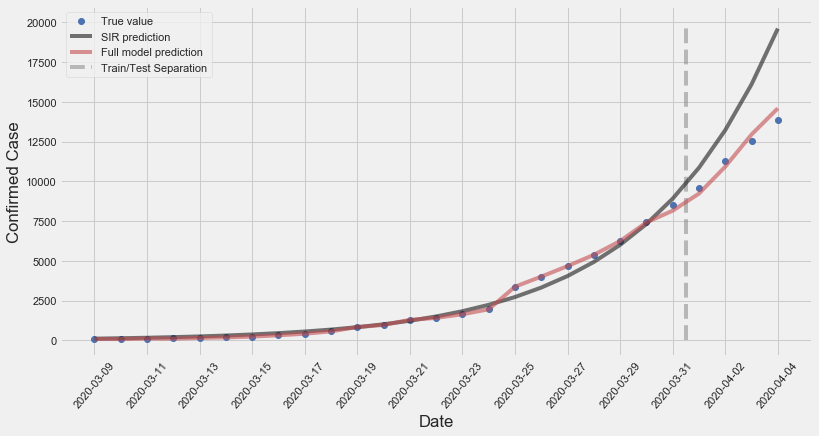

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(final_result['true_value'], 'bo')
plt.plot(final_result['sir_model_prediction'], 'k-', alpha=0.6)
plt.plot(final_result['full_model_prediction'], 'r-', alpha=0.6)
plt.vlines(22.5, ymin=0, ymax=20000, color='grey', linestyles='dashed', alpha=0.5)
plt.legend(['True value', 'SIR prediction', 'Full model prediction', 'Train/Test Separation'])
plt.xticks(range(0,27,2), final_result['prediction_date'][::2], rotation=50)
plt.xlabel('Date')
plt.ylabel('Confirmed Case')
plt.show()